# MLDM Project - DryBeans dataset analysis and classification

A.A. 2022/2023.

__Authors__:
 - Davide Marinoni
 - Samuele Ponzin

In [1]:
# LIBRARIES

# util
import warnings
import numpy as np
from sklearn.exceptions import UndefinedMetricWarning

# dataset analysis
import pandas as pd
from pandas._libs import json

# pre-processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
# --- feature extraction
from sklearn.decomposition import PCA
# --- feature selection
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif  # metrics for univariate feature selection
# --- class balancing
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN

# classification
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from imblearn.pipeline import Pipeline 
# - models
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# scoring
from sklearn.metrics import make_scorer, accuracy_score, plot_confusion_matrix
import sklearn.metrics as met
from sklearn.metrics import classification_report, confusion_matrix

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Functions

In [2]:
def class_balancing(df, method, labels):

    X = df[df.columns.tolist()[:-1]]
    y = df["Class"]

    if method == 'smote':
        sampler = SMOTE()
    elif method == 'adasyn':
        sampler = ADASYN()
    elif method == 'smote_tomek':
        sampler = SMOTETomek()
    elif method == 'smote_enn':
        sampler = SMOTEENN()
    
    X_resampled, y_resampled = sampler.fit_resample(X, y)
    df_train_smt = pd.merge(X_resampled, y_resampled, left_index=True, right_index=True)

    fig, ax = plt.subplots(figsize=(10,5))
    graph = sns.countplot(ax=ax, x='Class', data=df_train_smt, order=labels)
    graph.set_xticklabels(graph.get_xticklabels(),rotation=90)
    graph.bar_label(ax.containers[0]);
    ax.set_title(method.upper())

In [3]:
def univariate_feature_selection(df, method, criteria, threshold):
# this function will take in X, y variables with criteria, and return a dataframe with most important columns based on that criteria

# for classification of categorical classes using numerical attributes we use f_classif (ANOVA correlation coefficient)

    X = df[df.columns.tolist()[:-1]]
    y = df["Class"]

    # initialize our function/method
    if method == 'kbest':
        reg = SelectKBest(criteria, k=threshold).fit(X,y)
    elif method == 'percentile':
        reg = SelectPercentile(criteria, percentile=threshold).fit(X,y)

    # transform after creating the reg (so we can use getsupport)
    X_transformed = reg.transform(X)

    # filter down X based on kept columns
    X = X[[val for i,val in enumerate(X.columns) if reg.get_support()[i]]]

    univariate_df = pd.DataFrame(data = X, columns=X.columns)
    univariate_df = pd.concat([univariate_df, df[['Class']]], axis = 1)
    
    return univariate_df

In [4]:
def my_pca(df, n_components = 16,  bombay_dropped=False):

    if bombay_dropped:
        df = df[(df["Class"] != 'BOMBAY')]


    X = df[df.columns.tolist()[:-1]]
    y = df["Class"]

    # Standardizing the features
    X = StandardScaler().fit_transform(X)

    pca = PCA(n_components=n_components)

    principalComponents = pca.fit_transform(X)

    columns = []
    for i in range(1, n_components+1):
        columns.append('PC'+str(i))    
    
    pca_df = pd.DataFrame(data = principalComponents, columns=columns)

    pca_df = pd.concat([pca_df, df[['Class']]], axis = 1)

    print("\n".join("Variance of PC{}: {:0.6f}%".format(x, y) for x, y in zip(range(1,17), pca.explained_variance_ratio_*100)))
    print('\n')
    print("\n".join("Cumulative variance keeping at most {} PCA components: {:0.6f}%".format(x, y) for x, y in zip(range(1,17), np.cumsum(pca.explained_variance_ratio_*100))))

    return pca_df

In [5]:
def naive_classification(X_train, X_test, y_train, y_test):

    warnings.filterwarnings('ignore')
    # Baseline - comparing model accuracy using all features across classifiers
    classifiers = [
        DecisionTreeClassifier(),

        RandomForestClassifier(
            # min_samples_leaf=1, max_depth = None, bootstrap = True, 
            # oob_score = False, min_samples_split = 2, 
            # # free parameters
            # n_estimators=64, 
            # criterion='gini', 
            # max_features='sqrt'
            ),
        
        ExtraTreesClassifier(
            # min_samples_leaf=1, max_depth = None, bootstrap = False,
            # oob_score = False, min_samples_split = 2,
            # # free parameters
            # n_estimators=64, 
            # criterion='gini', 
            # max_features='sqrt'
            ),
        
        KNeighborsClassifier(
            # free parameters
            # algorithm='brute', 
            # n_neighbors=10
            ),
        
        SVC(
            # free parameters
            # kernel='rbf', 
            # gamma=0.05,
            # C=100, 
            # decision_function_shape='ovo'
            ),
        
        MLPClassifier(
            # alpha=1e-5, 
            # learning_rate='constant', 
            # max_iter=1000, 
            # tol=1e-4, 
            # verbose=False, 
            # momentum=0.9, 
            # early_stopping=False, 
            # # free parameters
            # activation='logistic',
            # solver='adam',
            # hidden_layer_sizes=(16,16),
            # learning_rate_init=0.01,
            ),

        
        # GaussianNB(),
        # LogisticRegression()
    ]

    # Naive Train Accuracy
    algo = ['DTC', 'RFC', 'ETC', 'KNN', 'SVC', 'MLP'] #'GNB', 'LR']
    # algo = []
    scores = []
    for clf in classifiers:
        # algo.append(clf.__class__.__name__)
        pipe = Pipeline([['over', None], ['scaler', StandardScaler()], ['classifier', clf]])
        scores.append(cross_val_score(pipe, X_train, y_train, cv=5).mean())
    warnings.filterwarnings('ignore')
    Naivescore_df_Train = pd.DataFrame({'Algorithm': algo, 'Score': scores}).set_index('Algorithm')

    # Naive Test Accuracy
    algo = ['DTC', 'RFC', 'ETC', 'KNN', 'SVC','MLP'] #'GNB', 'LR']
    # algo = []
    scores = []

    for clf in classifiers:
        pipe = Pipeline([['over', None], ['scaler', StandardScaler()], ['classifier', clf]])
        pipe = pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        # algo.append(clf.__class__.__name__)
        scores.append(accuracy_score(y_pred, y_test))
    warnings.filterwarnings('ignore')
    Naivescore_df_Test = pd.DataFrame({'Algorithm': algo, 'Score': scores}).set_index('Algorithm')

    # Bar plot between Train and Test Accuracy
    fig = plt.figure(figsize=(10, 6))  # Create matplotlib figure

    ax = fig.add_subplot(111)  # Create matplotlib axes
    ax2 = ax.twinx()  # Create another axes that shares the same x-axis as a
    width = .3

    Naivescore_df_Train.Score.plot(kind='bar', color='green', ax=ax, width=width, position=0)
    Naivescore_df_Test.Score.plot(kind='bar', color='red', ax=ax2, width=width, position=1)

    ax.grid(None, axis='y')
    ax2.grid(None)


    ax.set_xlabel('Algorithm', fontsize=12, loc='right')
    ax.set_ylabel('Train', fontsize=12)
    ax2.set_ylabel('Test', fontsize=12)
    ax.yaxis.label.set_color('green')
    ax2.yaxis.label.set_color('red')

    ax.set_xlim(-1, 6)
    ax.set_title("Accuracy of different models on the dataset after feature scaling.", fontsize=18)


In [6]:
def model_grid_search(X_train, X_test, y_train, y_test, scores, pipe, model_name, model_parameters_grid, n_cv = 5):
    
    # Creates an empty dictionary with best parameters for every scoring parameter considered
    best_parameters = {key: None for key in scores}

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(24,20), dpi=100, squeeze=False)
    fig.suptitle("Hyperparameters selection results: " + model_name.upper(), fontsize=22)

    print("\n================================================================================================================================================================\n")
    print("GRID SEARCH FOR " + model_name.upper() + ':')

    # Cross-validation **for every score!**
    for score, ax in zip(scores, ax.reshape(-1)):

        print("\n ---> Tuning " + model_name.upper() + " hyper-parameters for %s" % score.upper() + ": ")
        print()

        clf = GridSearchCV(
            estimator = pipe,
            param_grid = model_parameters_grid,
            scoring = score,
            n_jobs = -1,
            verbose = 4,
            return_train_score = True,
            cv = n_cv
            )

        # ignore divide-by-zero warnings, these occur inevitably in the parameter estimation phase and are annoying
        with warnings.catch_warnings():
            warnings.filterwarnings(action="ignore", category=UndefinedMetricWarning)
            # .. your divide-by-zero code ..
            clf.fit(X_train, y_train)


        # PLOTTING CROSS VALIDATION RESULTS:

        print("\n ---> Grid scores on development set:\n")
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("     ---> %r: %0.3f (+/-%0.03f) for %r" % (score, mean, std * 2, params))

        # FINAL CLASSIFICATION ON TEST SET WITH BEST PARAMETERS (THAT MAXIMISE THE CURRENT SCORE)
        
        print("\n ---> CLASSIFICATION ON THE TEST SET - Detailed classification report:")
        print("     --- The model is trained on the full development set.")
        print("     --- The scores are computed on the full evaluation set.\n")
        
        # PLOT RESULTS

        # ignore divide-by-zero warnings, these occur inevitably in the parameter estimation phase and are annoying
        with warnings.catch_warnings():
            warnings.filterwarnings(action="ignore", category=UndefinedMetricWarning)
            # .. your divide-by-zero code ..
            y_true, y_pred = y_test, clf.predict(X_test)
            print(classification_report(y_true, y_pred))
        print()

        print("\n ---> BEST PARAMETERS SET found on development set:\n")
        print(clf.best_params_)
        best_parameters[score] = clf.best_params_

        print("\n------------------------------------------------------------------------------------------------------------------------------------------------------------------\n")
        
        # PLOT CONFUSION MATRIX

        cm = confusion_matrix(y_test, y_pred, normalize='true')
        sns.heatmap(cm, annot=True, fmt='.2%', cmap='icefire', ax=ax)
        ax.set_title('Grid search results obtained trying to maximise for: ' + score.upper())

        # set x-axis label and ticks. 
        ax.set_xlabel("Predicted Class", fontsize=14)
        ax.xaxis.set_ticklabels(['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA'])

        # set y-axis label and ticks
        ax.set_ylabel("Actual Class", fontsize=14)
        ax.yaxis.set_ticklabels(['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA'])

        
    return best_parameters

In [7]:
def pipeline_final_traintest(X_train, X_test, y_train, y_test, selected_score, pipe, model_name, best_parameters):
    
    # Print the best parameters configurations that maximise specific metric/scores
    print(" ---> List of the parameters used according to a specific scoring parameter: <--- \n")
    print(json.dumps(best_parameters, indent=4))
    print()

    # Final classification with optimized parameters:
    print("\n# Classification:")
    
    # Instantiate a new classifier object with best parameters for a selected scoring parameter
    clf = pipe
    clf.set_params(**best_parameters[selected_score])
    
    # Model training:
    print("\n ---> Model training:")
    print("\n   (!) Using the set of hyperparameters found doing grid seach trying to maximise %s" % selected_score.upper())
    with warnings.catch_warnings():
        warnings.filterwarnings(action="ignore", category=UndefinedMetricWarning)
        # .. your divide-by-zero code ..
        clf.fit(X_train, y_train)

    # Model testing:
    print("\n ---> Making predictions:")
    with warnings.catch_warnings():
        warnings.filterwarnings(action="ignore", category=UndefinedMetricWarning)
        # .. your divide-by-zero code ..
        y_predicted = clf.predict(X_test)

        # Performance evaluation
        print("\n    Plotting the Confusion Matrix:\n")
        print(confusion_matrix(y_test, y_predicted))
        print()

        report = classification_report(y_test, y_predicted)
        print(report)
        print()

    
    # PLOT CONFUSION MATRIX

    fig = plt.figure(figsize=(10, 8))  # figure size is given as a (width, height) tuple
    ax1 = fig.add_subplot(111)
    cm = confusion_matrix(y_test, y_predicted, normalize='true')
    sns.heatmap(cm, annot=True, fmt='.2%', cmap='icefire', ax=ax1)
    ax1.set_title('Confusion matrix obtianed with ' + model_name.upper(), fontsize=18, pad=20)

    # set x-axis label and ticks. 
    ax1.set_xlabel("Predicted Class", fontsize=14)
    ax1.xaxis.set_ticklabels(['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA'])

    # set y-axis label and ticks
    ax1.set_ylabel("Actual Class", fontsize=14)
    ax1.yaxis.set_ticklabels(['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA'])
    
    return clf, report

# Dry Beans

## Dataset analysis

In [8]:
# Import dataset
df = pd.read_excel("DryBeanDataset/Dry_Bean_Dataset.xlsx")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             13611 non-null  int64  
 1   Perimeter        13611 non-null  float64
 2   MajorAxisLength  13611 non-null  float64
 3   MinorAxisLength  13611 non-null  float64
 4   AspectRation     13611 non-null  float64
 5   Eccentricity     13611 non-null  float64
 6   ConvexArea       13611 non-null  int64  
 7   EquivDiameter    13611 non-null  float64
 8   Extent           13611 non-null  float64
 9   Solidity         13611 non-null  float64
 10  roundness        13611 non-null  float64
 11  Compactness      13611 non-null  float64
 12  ShapeFactor1     13611 non-null  float64
 13  ShapeFactor2     13611 non-null  float64
 14  ShapeFactor3     13611 non-null  float64
 15  ShapeFactor4     13611 non-null  float64
 16  Class            13611 non-null  object 
dtypes: float64(1

### Dataset cleaning

In [9]:
df = df.drop_duplicates(ignore_index=True)
df.rename(columns = {'AspectRation':'AspectRatio'}, inplace = True)
df.rename(columns = {'roundness':'Roundness'}, inplace = True)
df.rename(columns = {'EquivDiameter':'EquivalentDiameter'}, inplace = True)

df = df.astype({'Area': 'float64'})
df = df.astype({'ConvexArea': 'float64'})
df = df.astype({'Class': 'string'})

labels = ['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink']

features = df.columns.to_list();
features.remove('Class');
# features = ['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'AspectRatio', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 
#             'Extent', 'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2','ShapeFactor3', 'ShapeFactor4'];

df.info()


pd.set_option('display.float_format', lambda x: '%.3E' % x)

df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13543 entries, 0 to 13542
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Area                13543 non-null  float64
 1   Perimeter           13543 non-null  float64
 2   MajorAxisLength     13543 non-null  float64
 3   MinorAxisLength     13543 non-null  float64
 4   AspectRatio         13543 non-null  float64
 5   Eccentricity        13543 non-null  float64
 6   ConvexArea          13543 non-null  float64
 7   EquivalentDiameter  13543 non-null  float64
 8   Extent              13543 non-null  float64
 9   Solidity            13543 non-null  float64
 10  Roundness           13543 non-null  float64
 11  Compactness         13543 non-null  float64
 12  ShapeFactor1        13543 non-null  float64
 13  ShapeFactor2        13543 non-null  float64
 14  ShapeFactor3        13543 non-null  float64
 15  ShapeFactor4        13543 non-null  float64
 16  Clas

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRatio,Eccentricity,ConvexArea,EquivalentDiameter,Extent,Solidity,Roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
count,1.354E+04,1.354E+04,1.354E+04,1.354E+04,1.354E+04,1.354E+04,1.354E+04,1.354E+04,1.354E+04,1.354E+04,1.354E+04,1.354E+04,1.354E+04,1.354E+04,1.354E+04,1.354E+04
mean,5.305E+04,8.550E+02,3.199E+02,2.024E+02,1.581E+00,7.503E-01,5.377E+04,2.530E+02,7.498E-01,9.872E-01,8.737E-01,8.004E-01,6.561E-03,1.719E-03,6.443E-01,9.951E-01
std,2.939E+04,2.147E+02,8.581E+01,4.505E+01,2.452E-01,9.186E-02,2.984E+04,5.931E+01,4.894E-02,4.650E-03,5.939E-02,6.146E-02,1.130E-03,5.955E-04,9.865E-02,4.347E-03
min,2.042E+04,5.247E+02,1.836E+02,1.225E+02,1.025E+00,2.190E-01,2.068E+04,1.612E+02,5.553E-01,9.192E-01,4.896E-01,6.406E-01,2.778E-03,5.642E-04,4.103E-01,9.477E-01
25%,3.628E+04,7.032E+02,2.531E+02,1.759E+02,1.431E+00,7.151E-01,3.667E+04,2.149E+02,7.187E-01,9.857E-01,8.334E-01,7.632E-01,5.893E-03,1.158E-03,5.825E-01,9.937E-01
50%,4.458E+04,7.939E+02,2.964E+02,1.925E+02,1.550E+00,7.640E-01,4.512E+04,2.382E+02,7.599E-01,9.883E-01,8.835E-01,8.015E-01,6.643E-03,1.700E-03,6.424E-01,9.964E-01
75%,6.138E+04,9.771E+02,3.763E+02,2.172E+02,1.704E+00,8.097E-01,6.236E+04,2.796E+02,7.868E-01,9.900E-01,9.170E-01,8.345E-01,7.270E-03,2.173E-03,6.963E-01,9.979E-01
max,2.546E+05,1.985E+03,7.389E+02,4.602E+02,2.430E+00,9.114E-01,2.633E+05,5.694E+02,8.662E-01,9.947E-01,9.907E-01,9.873E-01,1.045E-02,3.665E-03,9.748E-01,9.997E-01


### Feature distribution analysis

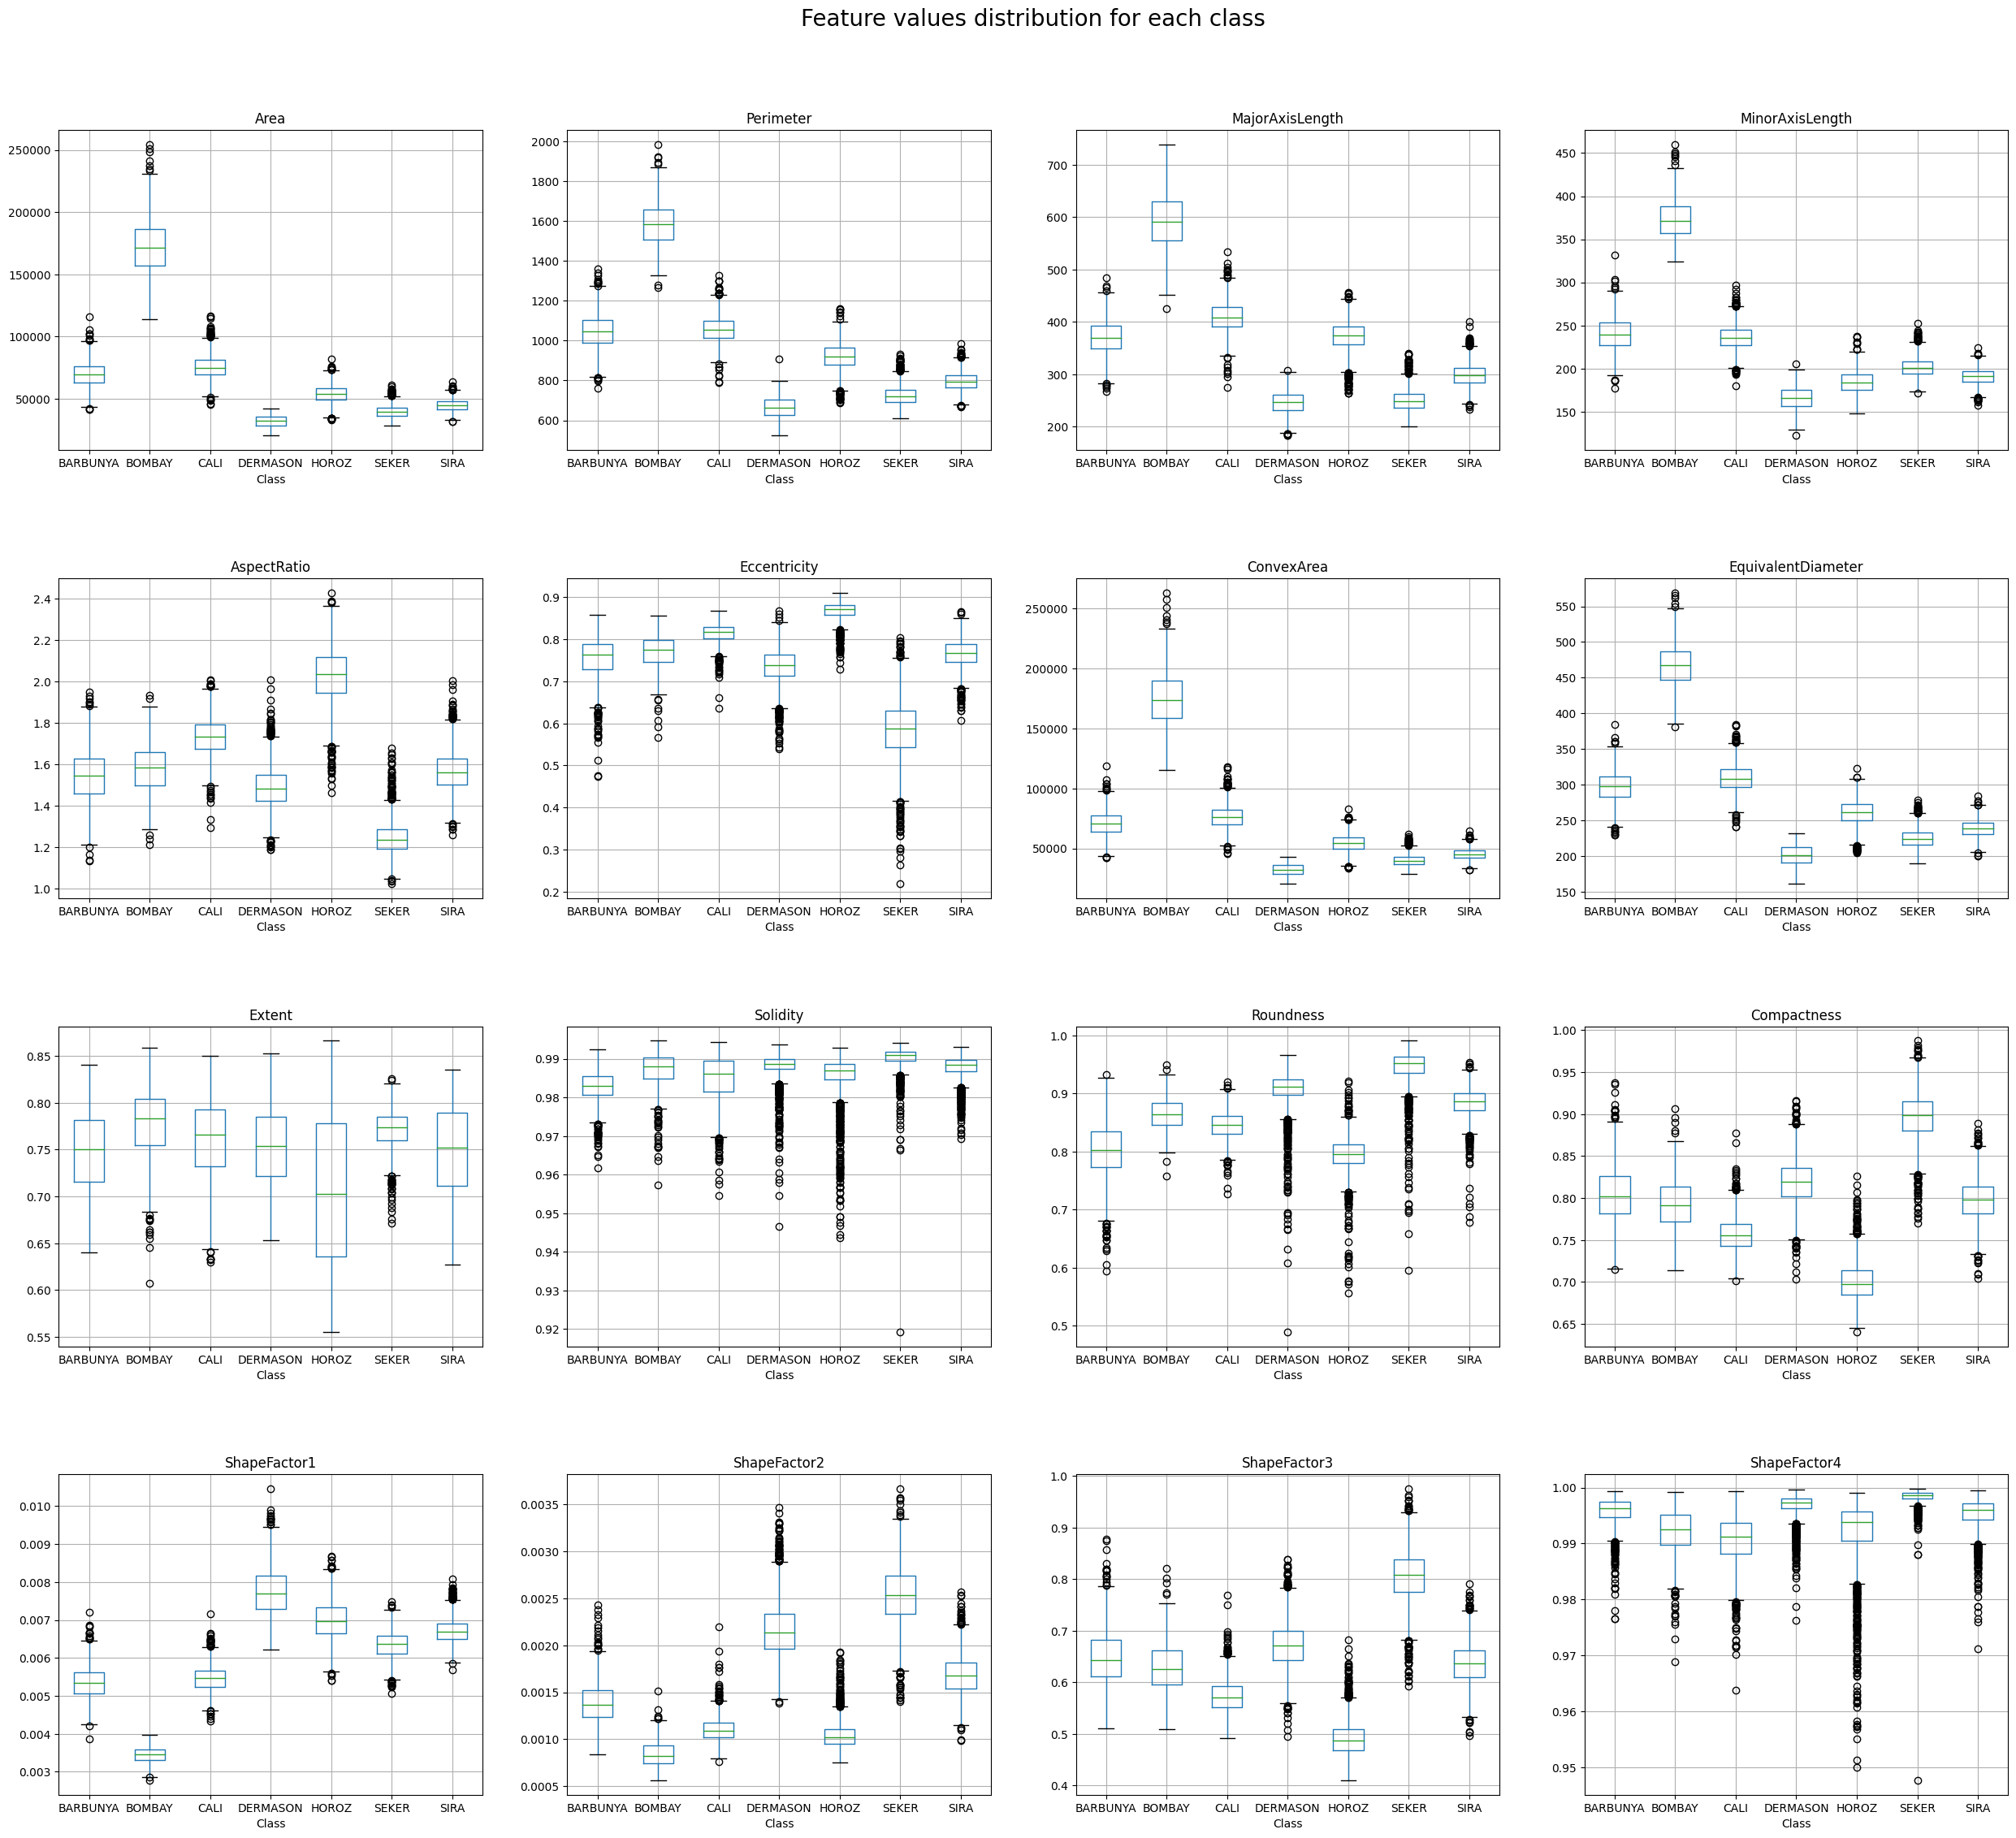

In [10]:
# BOXPLOTS
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(30, 25))
for feature, ax in zip(features, ax.reshape(-1)):
    df.boxplot(feature, by='Class', ax=ax)
    # ax.axis('scaled')
plt.subplots_adjust()
fig.suptitle("Feature values distribution for each class", fontsize=20);
# fig.tight_layout()
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.92,
                    wspace=0.2,
                    hspace=0.4)
# fig.tight_layout(rect=[0, 0.03, 1, 0.98])

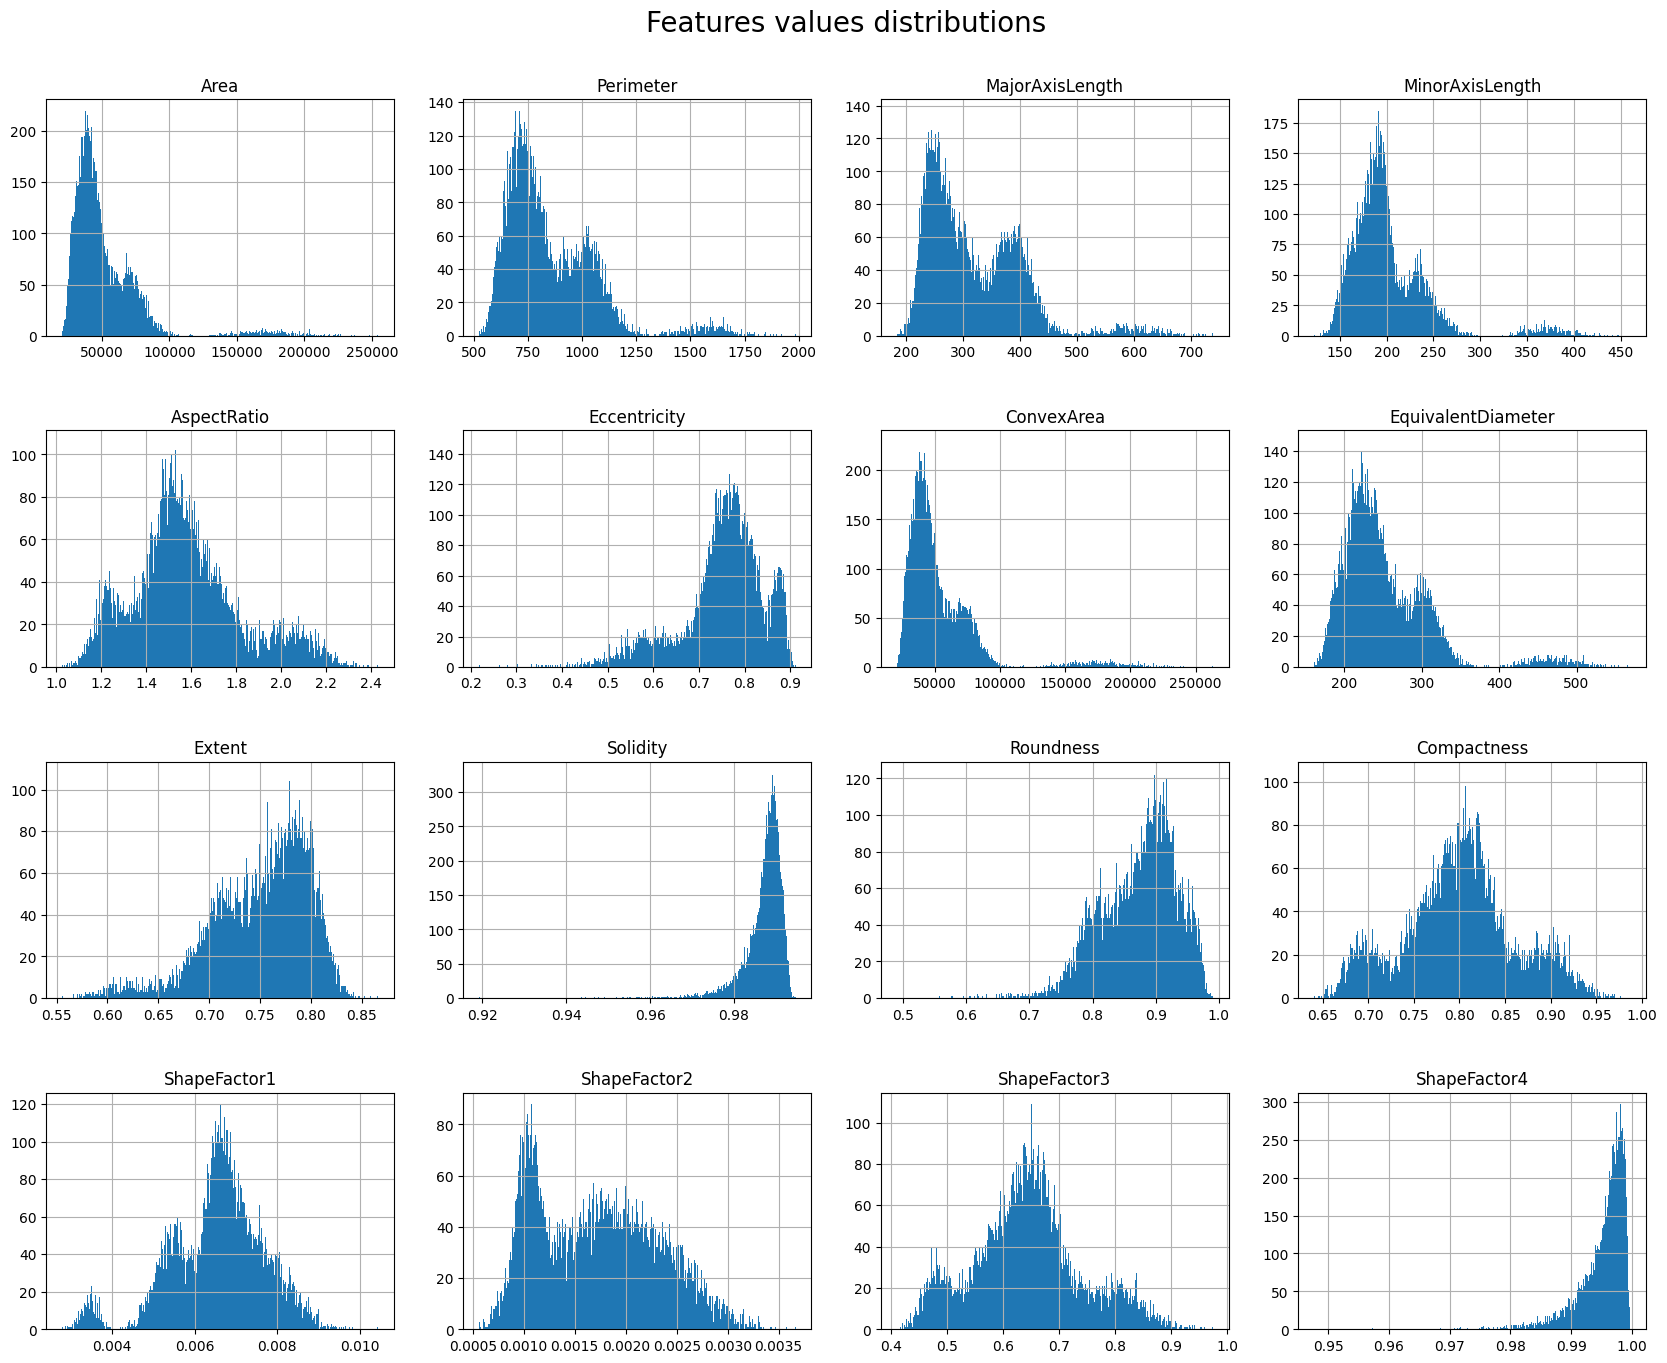

In [11]:
# HISTOGRAMS

fig, ax = fig, ax = plt.subplots(4,4,figsize=(20,15))  #(20,30)
df.hist(bins=500, ax=ax); #Note: Through this plot we noticed the first correlations through shape
#df.groupby('Class').hist(figsize=(20,15),bins=100); #Note: It is not informative for our purposes
fig.suptitle('Features values distributions', fontsize=20)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.92,
                    wspace=0.2,
                    hspace=0.4)
# fig.tight_layout(rect=[0, 0.03, 1, 0.98])

### Class distribution analysis

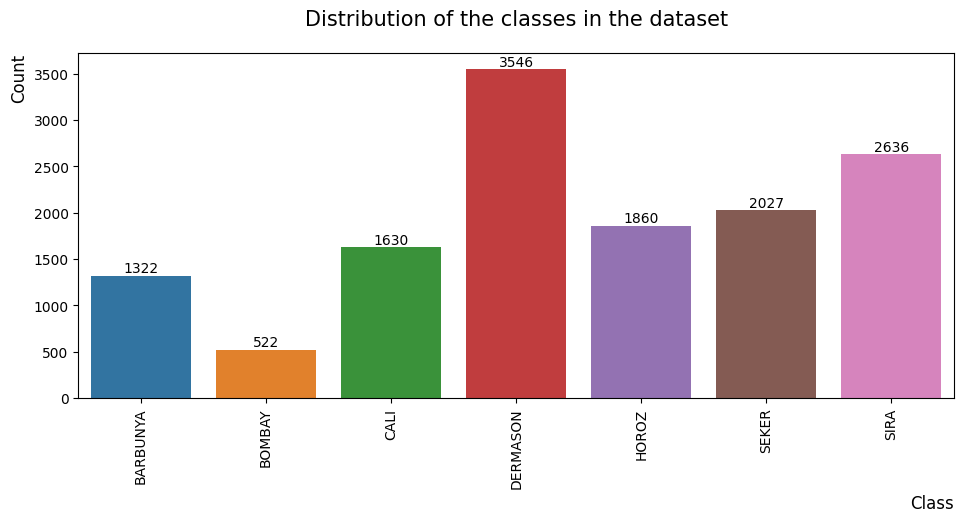

In [12]:
# CLASSES ANALYSIS

fig, ax = plt.subplots(figsize=(10,5))
graph = sns.countplot(ax=ax, x='Class', data=df, order=labels)
graph.set_xticklabels(graph.get_xticklabels(),rotation=90)
graph.bar_label(ax.containers[0])
fig.tight_layout(rect=[0.01, 0.01, 0.98, 0.98])
ax.set_title('Distribution of the classes in the dataset', fontsize=15, pad=20)
ax.set_ylabel('Count', loc='top', fontsize=12)
ax.set_xlabel('Class', loc='right', fontsize=12);

#### Dropping the BOMBAY class

After observing the multivariate feature distribution we tried to dropp the BOMBAY class in order to see if it could improve the classification of the other classes.
If so, it could be possible to create a binary classifier for this class and successively classify the other classes.

In [13]:
#df = df[(df["Class"] != 'BOMBAY')];

## Pre-processing

### Class balancing: oversampling & hybridization

Here we explore the effect of different class balancing methods, we do not create copies of the original dataset applying these methods because these are implemented in the pipeline used in classification.

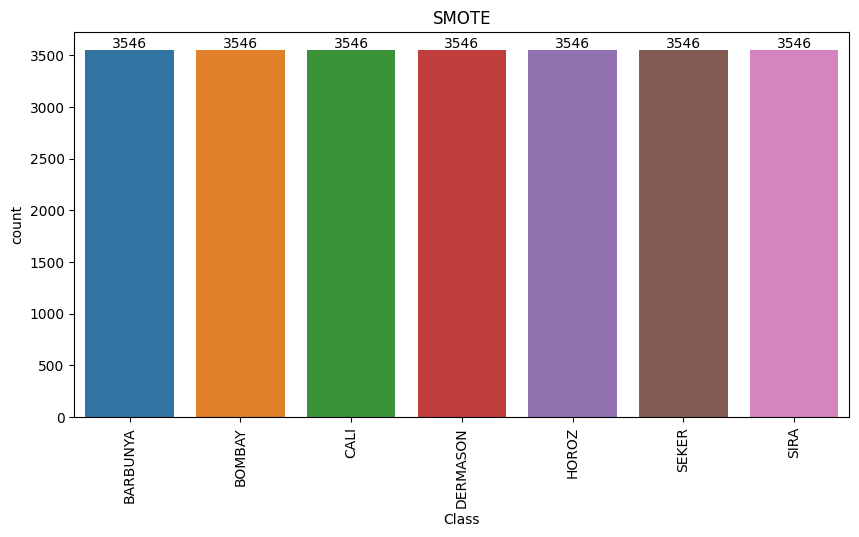

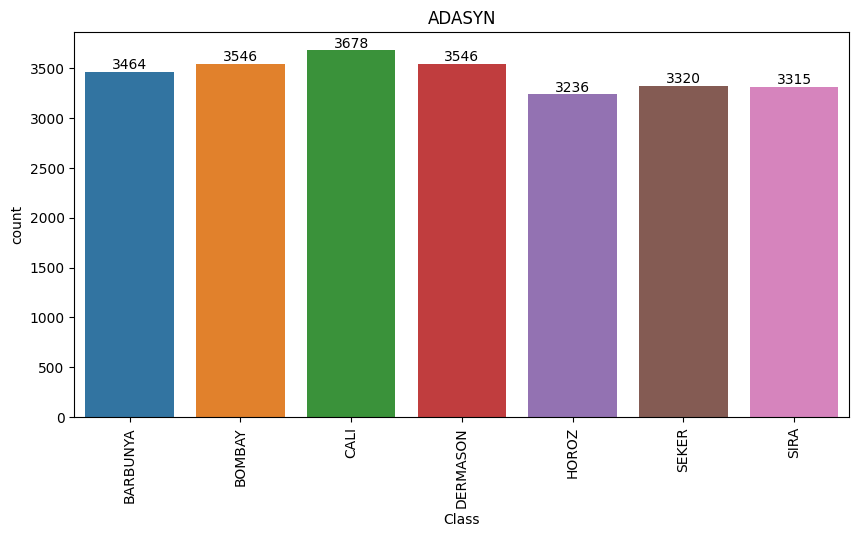

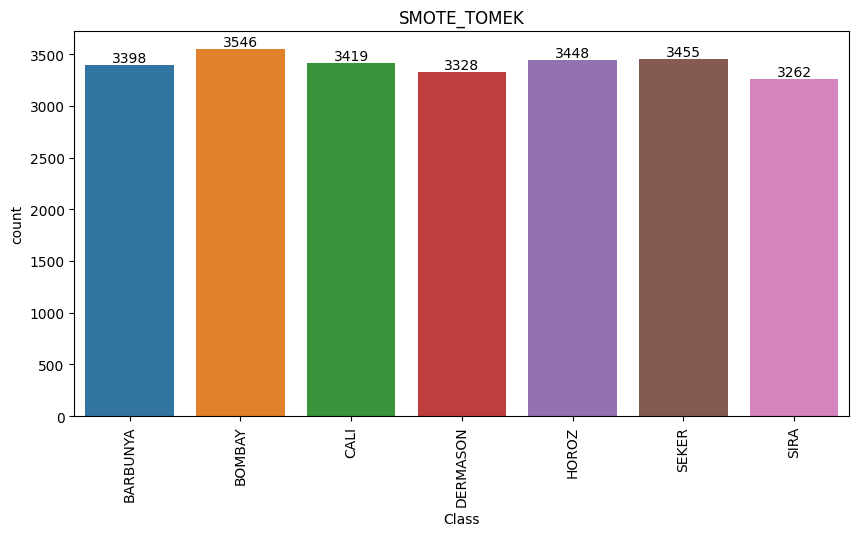

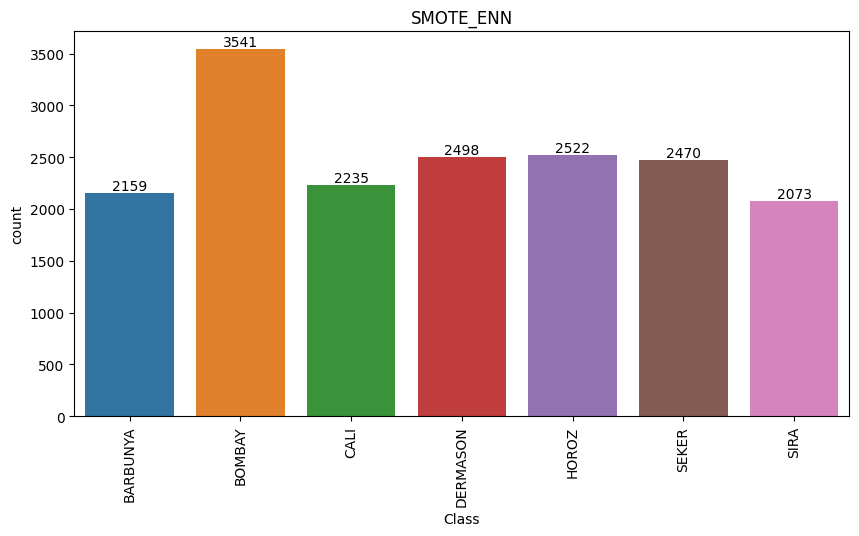

In [14]:
# OVERSAMPLING - SMOTE
class_balancing(df, 'smote', labels)

# OVERSAMPLING - ADASYN
class_balancing(df, 'adasyn', labels)

# HYBRIDIZATION - SMOTE TOMEK
class_balancing(df, 'smote_tomek', labels)

# HYBRIDIZATION - SMOTE ENN
class_balancing(df, 'smote_enn', labels)

### Feature Selection

Here we explore different methods of feature selections. 

Every method is applied to the original datasets and a new dataset is created and stored in a dictionary _datasets_.

In [15]:
datasets = {}
datasets['dataset_raw'] = df

#### A) Manual feature dropping after qualitative analysis

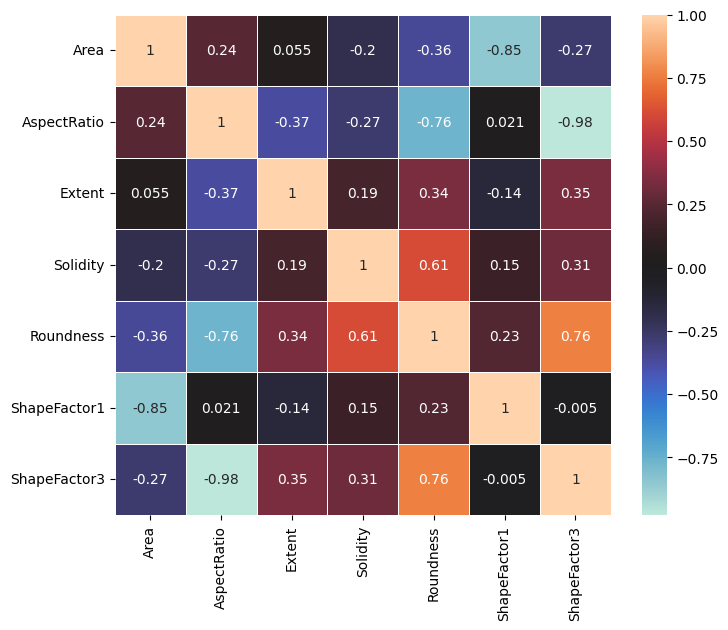

In [16]:
# ARBITRARY DROPPING BY CORRELATION ANALYSIS
# Note: Area and ConvexArea are almost perfectly correlated: we already noticed that mathematically one is the square root of the other.
# Note: Compactness and Shape Factor 3 are almost perfectly correlated
# Proposition: Erase ConvexArea and Compactness

df_A = df.drop(['Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'ConvexArea', 'EquivalentDiameter', 'Eccentricity', 'Compactness', 'ShapeFactor2', 'ShapeFactor4'], axis=1)

fig, ax = plt.subplots(figsize=(8,6.5))
sns.heatmap( df_A.corr(numeric_only = True), annot=True, linewidths=.5, cmap="icefire",ax=ax); # cmap="rocket_r" """

datasets['dataset_A'] = df_A

#### B) Automatic feature dropping after correlation analysis

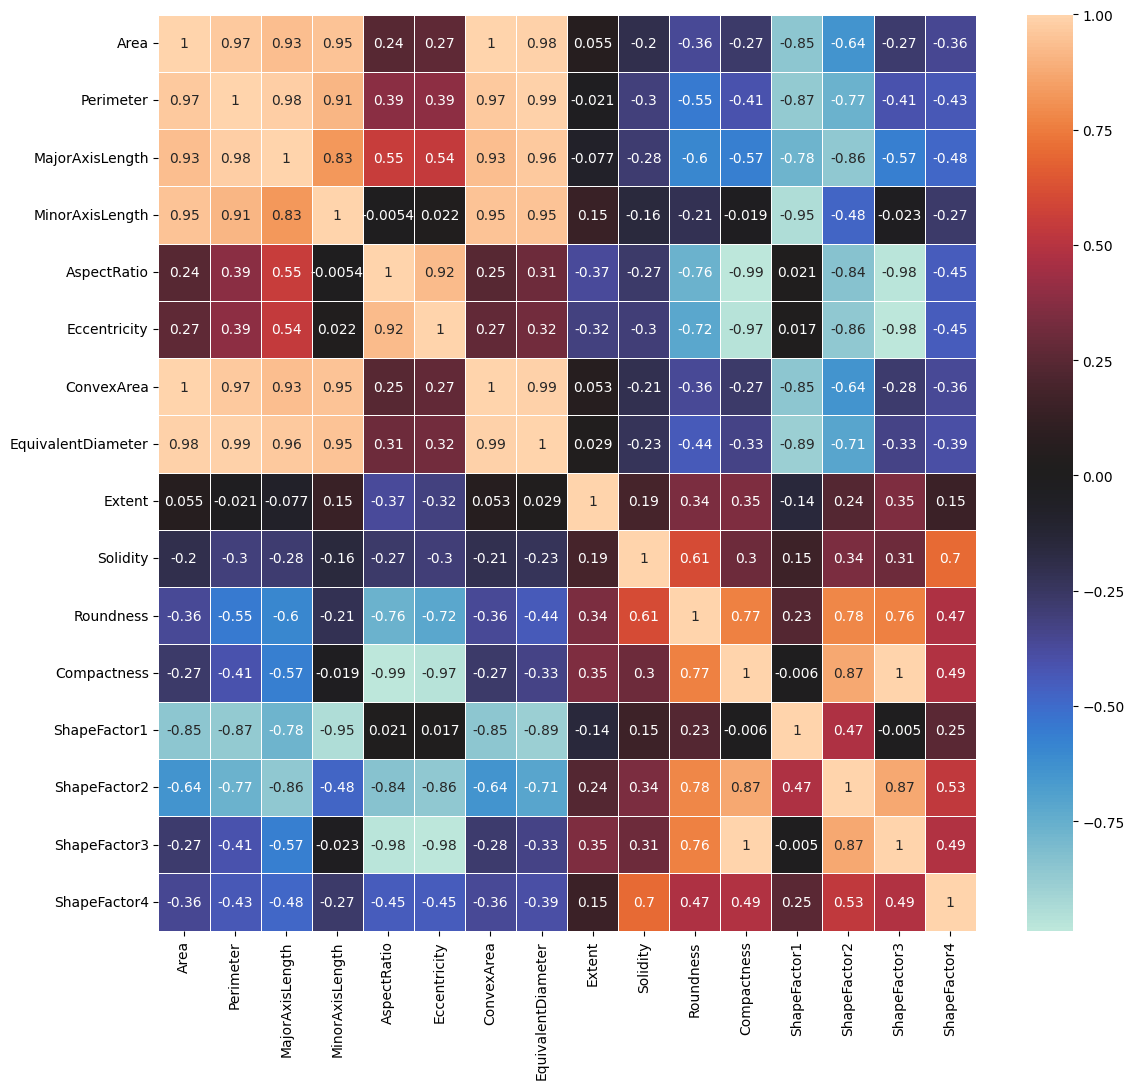

In [17]:
# CORRELATION
fig, ax = plt.subplots(figsize=(12,11)) 
CORR_MAP = df.corr(numeric_only = True)
# CORR_MAP = df.corr(numeric_only = True).abs()
Steep = 10.0
Stretch = 2.002
if Stretch < 2.0 :
    Stretch = 2.0 
HIGH_CORR = (np.tan((np.pi/Stretch) * np.abs(CORR_MAP)) * (1 / Steep)) #LOW INFORMATION
LOW_CORR  = (np.tan((np.pi/Stretch) * (1 - np.abs(CORR_MAP))) * (1 / Steep)) #HIGH INFORMATION

sns.heatmap(CORR_MAP,annot=True,linewidths=.5, cmap="icefire"); # cmap="rocket_r"
#sns.heatmap(HIGH_CORR,annot=True,linewidths=.5, cmap="flare"); # cmap="rocket_r"
#sns.heatmap(LOW_CORR,annot=True,linewidths=.5, cmap="flare"); # cmap="rocket_r"

fig.tight_layout()

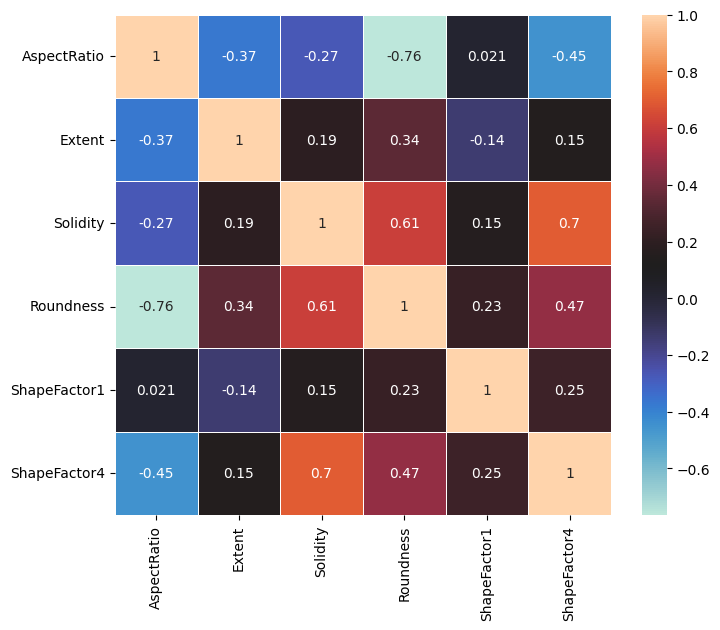

In [18]:
# PRUNING BY CORRELATION
P_THRESHOLD = 0.80

corr = df.corr(numeric_only = True).abs()
drop = []
hold = []

for i in range(0,corr.shape[0]):
    for j in range(i+1,corr.shape[1]):
        if corr.iloc[i,j]>=P_THRESHOLD:
            feature_i_corrsum = corr.iloc[i,:].sum()
            feature_j_corrsum = corr.iloc[j,:].sum()
            if feature_i_corrsum <= feature_j_corrsum:
                #hold.append(corr.index[i])
                #drop.append(corr.index[j])
                hold.append(i)
                drop.append(j)                
            else:
                #drop.append(corr.index[i])
                #hold.append(corr.index[j])
                drop.append(i)
                hold.append(j)

drop = list(set(drop))
drop = [list(corr.index)[i] for i in drop]
df_B = df.drop(drop, axis=1) 
corr = df_B.corr(numeric_only = True)

fig, ax = plt.subplots(figsize=(8,6.5))
sns.heatmap(corr, annot=True, linewidths=.5, cmap="icefire", ax=ax); # cmap="rocket_r" """

datasets['dataset_B'] = df_B

#### C) Random Forest feature importance

In [19]:
# RANDOM FOREST FEATURE IMPORTANCE
N_FEATURES_TO_KEEP = 6

Xf = df.iloc[:,:-1]
yf = df.iloc[:,-1:]
X_train_f, X_test_f, y_train_f, y_test_f  = train_test_split(Xf, yf, test_size=0.3)

rnd_clf = RandomForestClassifier(
    n_estimators = 64, 
    criterion="gini",                      # {"gini", "entropy", "log_loss"}  
    min_samples_split = 2,
    max_features = "sqrt",                 # {"sqrt", "log2", None}
    bootstrap = True,
    oob_score = False,
    min_samples_leaf = 1, 
    max_depth = None
    )
rnd_clf.fit(X_train_f, y_train_f.values.ravel())

y_pred_rf = rnd_clf.predict(X_test_f)
print(met.classification_report(y_pred_rf, y_test_f));

feat_score = rnd_clf.feature_importances_

features_importances = pd.DataFrame(list(zip(features, feat_score)), columns =['features', 'score']);
features_importances = features_importances.sort_values(by=['score'], ascending=False);
features_importances = features_importances.reset_index(drop = True);
No_of_best = N_FEATURES_TO_KEEP
if No_of_best < 1 or No_of_best > len(features_importances):
    No_of_best = len(features_importances)
best_features = features_importances.iloc[:No_of_best,0].tolist()
best_features.append('Class')

df_C = df.filter(best_features , axis=1);
datasets['dataset_C'] = df_C 

              precision    recall  f1-score   support

    BARBUNYA       0.90      0.93      0.92       411
      BOMBAY       0.99      1.00      1.00       158
        CALI       0.93      0.93      0.93       468
    DERMASON       0.93      0.91      0.92      1080
       HOROZ       0.96      0.95      0.95       566
       SEKER       0.94      0.94      0.94       596
        SIRA       0.86      0.88      0.87       784

    accuracy                           0.92      4063
   macro avg       0.93      0.93      0.93      4063
weighted avg       0.92      0.92      0.92      4063



In [20]:
df_C.describe()

,ShapeFactor1,ShapeFactor3,Compactness,Perimeter,MajorAxisLength,MinorAxisLength
count,1.354E+04,1.354E+04,1.354E+04,1.354E+04,1.354E+04,1.354E+04
mean,6.561E-03,6.443E-01,8.004E-01,8.550E+02,3.199E+02,2.024E+02
std,1.130E-03,9.865E-02,6.146E-02,2.147E+02,8.581E+01,4.505E+01
min,2.778E-03,4.103E-01,6.406E-01,5.247E+02,1.836E+02,1.225E+02
25%,5.893E-03,5.825E-01,7.632E-01,7.032E+02,2.531E+02,1.759E+02
50%,6.643E-03,6.424E-01,8.015E-01,7.939E+02,2.964E+02,1.925E+02
75%,7.270E-03,6.963E-01,8.345E-01,9.771E+02,3.763E+02,2.172E+02
max,1.045E-02,9.748E-01,9.873E-01,1.985E+03,7.389E+02,4.602E+02


#### D) Univariate feature selection

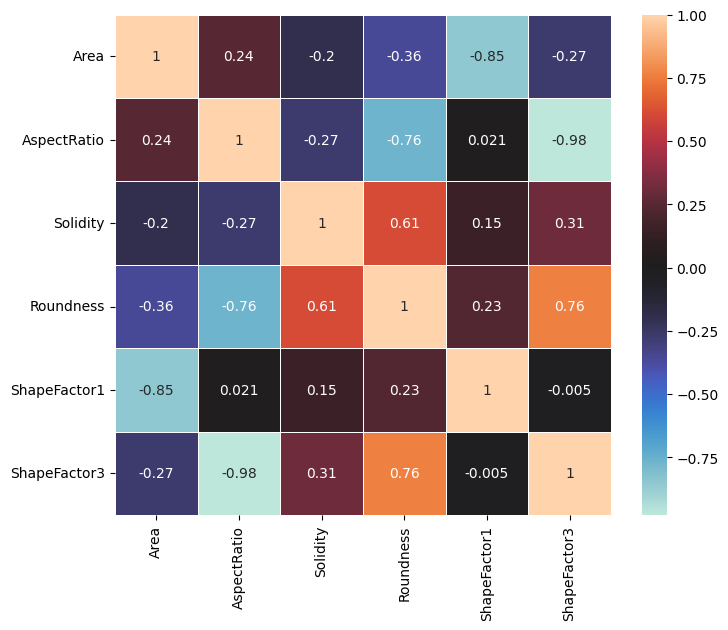

In [21]:
# Extracting data
criteria = f_classif
method = 'kbest' # ['kbest', 'percentile']
threshold = 6  # [6, 10%]

# feature selection with f_classif (ANOVA correlation coefficient)
df_D = univariate_feature_selection(df_A, method, criteria, threshold)

fig, ax = plt.subplots(figsize=(8,6.5))
sns.heatmap(df_D.corr(numeric_only=True),annot=True,linewidths=.5, cmap="icefire",ax=ax); # cmap="rocket_r" """

datasets['dataset_D'] = df_D

In [22]:
df_D.describe()

,Area,AspectRatio,Solidity,Roundness,ShapeFactor1,ShapeFactor3
count,1.354E+04,1.354E+04,1.354E+04,1.354E+04,1.354E+04,1.354E+04
mean,5.305E+04,1.581E+00,9.872E-01,8.737E-01,6.561E-03,6.443E-01
std,2.939E+04,2.452E-01,4.650E-03,5.939E-02,1.130E-03,9.865E-02
min,2.042E+04,1.025E+00,9.192E-01,4.896E-01,2.778E-03,4.103E-01
25%,3.628E+04,1.431E+00,9.857E-01,8.334E-01,5.893E-03,5.825E-01
50%,4.458E+04,1.550E+00,9.883E-01,8.835E-01,6.643E-03,6.424E-01
75%,6.138E+04,1.704E+00,9.900E-01,9.170E-01,7.270E-03,6.963E-01
max,2.546E+05,2.430E+00,9.947E-01,9.907E-01,1.045E-02,9.748E-01


### Feature Extraction (alternative to Feature Selection)

#### PCA

In [23]:
df_pca = my_pca(df, n_components=8)
datasets['dataset_PCA'] = df_pca

Variance of PC1: 55.546808%
Variance of PC2: 26.360789%
Variance of PC3: 7.984404%
Variance of PC4: 5.108438%
Variance of PC5: 2.753101%
Variance of PC6: 1.152172%
Variance of PC7: 0.698225%
Variance of PC8: 0.325960%


Cumulative variance keeping at most 1 PCA components: 55.546808%
Cumulative variance keeping at most 2 PCA components: 81.907597%
Cumulative variance keeping at most 3 PCA components: 89.892001%
Cumulative variance keeping at most 4 PCA components: 95.000439%
Cumulative variance keeping at most 5 PCA components: 97.753540%
Cumulative variance keeping at most 6 PCA components: 98.905712%
Cumulative variance keeping at most 7 PCA components: 99.603937%
Cumulative variance keeping at most 8 PCA components: 99.929897%


In [24]:
df_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
count,1.354E+04,1.354E+04,1.354E+04,1.354E+04,1.354E+04,1.354E+04,1.354E+04,1.354E+04
mean,-1.343E-16,0.000E+00,-8.395E-18,8.395E-18,3.358E-17,-1.679E-17,-1.679E-17,-1.259E-17
std,2.981E+00,2.054E+00,1.130E+00,9.041E-01,6.637E-01,4.294E-01,3.343E-01,2.284E-01
min,-6.343E+00,-6.016E+00,-2.821E+00,-2.959E+00,-4.129E+00,-1.479E+00,-9.759E-01,-1.180E+00
25%,-2.442E+00,-1.175E+00,-6.342E-01,-6.303E-01,-3.410E-01,-2.828E-01,-2.420E-01,-1.302E-01
50%,-5.634E-01,-1.877E-01,-1.555E-01,-4.663E-02,-9.719E-02,-9.130E-02,-6.373E-02,6.223E-03
75%,2.374E+00,1.001E+00,4.155E-01,6.727E-01,2.072E-01,1.925E-01,1.836E-01,1.299E-01
max,1.323E+01,9.193E+00,1.774E+01,3.213E+00,4.497E+00,3.437E+00,2.278E+00,1.511E+00


## Classification

**ATTENTION**: Class Balancing cannot be done a priori since we perform K-Fold Cross Validation! It's included in a pipeline along with standard scaling.

### Pre-processed dataset selection for classification

Select one among:
 - dataset_raw: oriignal dataset containg all the features
 - dataset_A: manual dropping after correlation analysis
 - dataset_B: automatic dropping after correlation analysis
 - dataset_C: random forest feature importance
 - dataset_D: univariate feature selection
 - dataset_PCA: pca feature extraction for dimensionality reduction

In [25]:
chosen_df = datasets['dataset_B']

In [26]:
X = chosen_df[chosen_df.columns.tolist()[:-1]]
y = chosen_df["Class"]

### Train test split

Select the percentage of instances to keep away for testing the model.

In [27]:
# Train test split
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42)

### Naive classification

Simple routine done to observe how different classifiers perform on the dataset without proper hyperparameters selection.

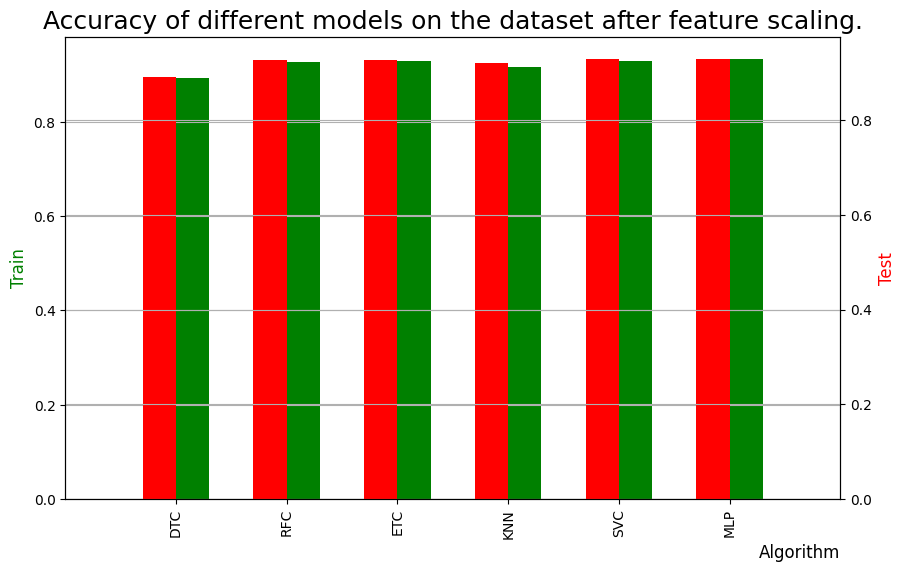

In [28]:
naive_classification(X_train, X_test, y_train, y_test)

### Hyperparameter selection (grid search and k-fold cross-validation)



GRID SEARCH FOR DECISION_TREE:

 ---> Tuning DECISION_TREE hyper-parameters for ACCURACY: 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END Decision_Tree__criterion=gini, Decision_Tree__max_depth=12, Decision_Tree__splitter=best;, score=(train=0.962, test=0.901) total time=   0.5s
[CV 3/5] END Decision_Tree__criterion=gini, Decision_Tree__max_depth=12, Decision_Tree__splitter=best;, score=(train=0.961, test=0.911) total time=   0.4s
[CV 2/5] END Decision_Tree__criterion=gini, Decision_Tree__max_depth=12, Decision_Tree__splitter=best;, score=(train=0.956, test=0.904) total time=   0.5s
[CV 5/5] END Decision_Tree__criterion=gini, Decision_Tree__max_depth=12, Decision_Tree__splitter=best;, score=(train=0.960, test=0.906) total time=   0.5s
[CV 4/5] END Decision_Tree__criterion=gini, Decision_Tree__max_depth=12, Decision_Tree__splitter=best;, score=(train=0.961, test=0.909) total time=   0.5s

 ---> Grid scores on development set:

     ---> 'accuracy': 0.906 (+/-

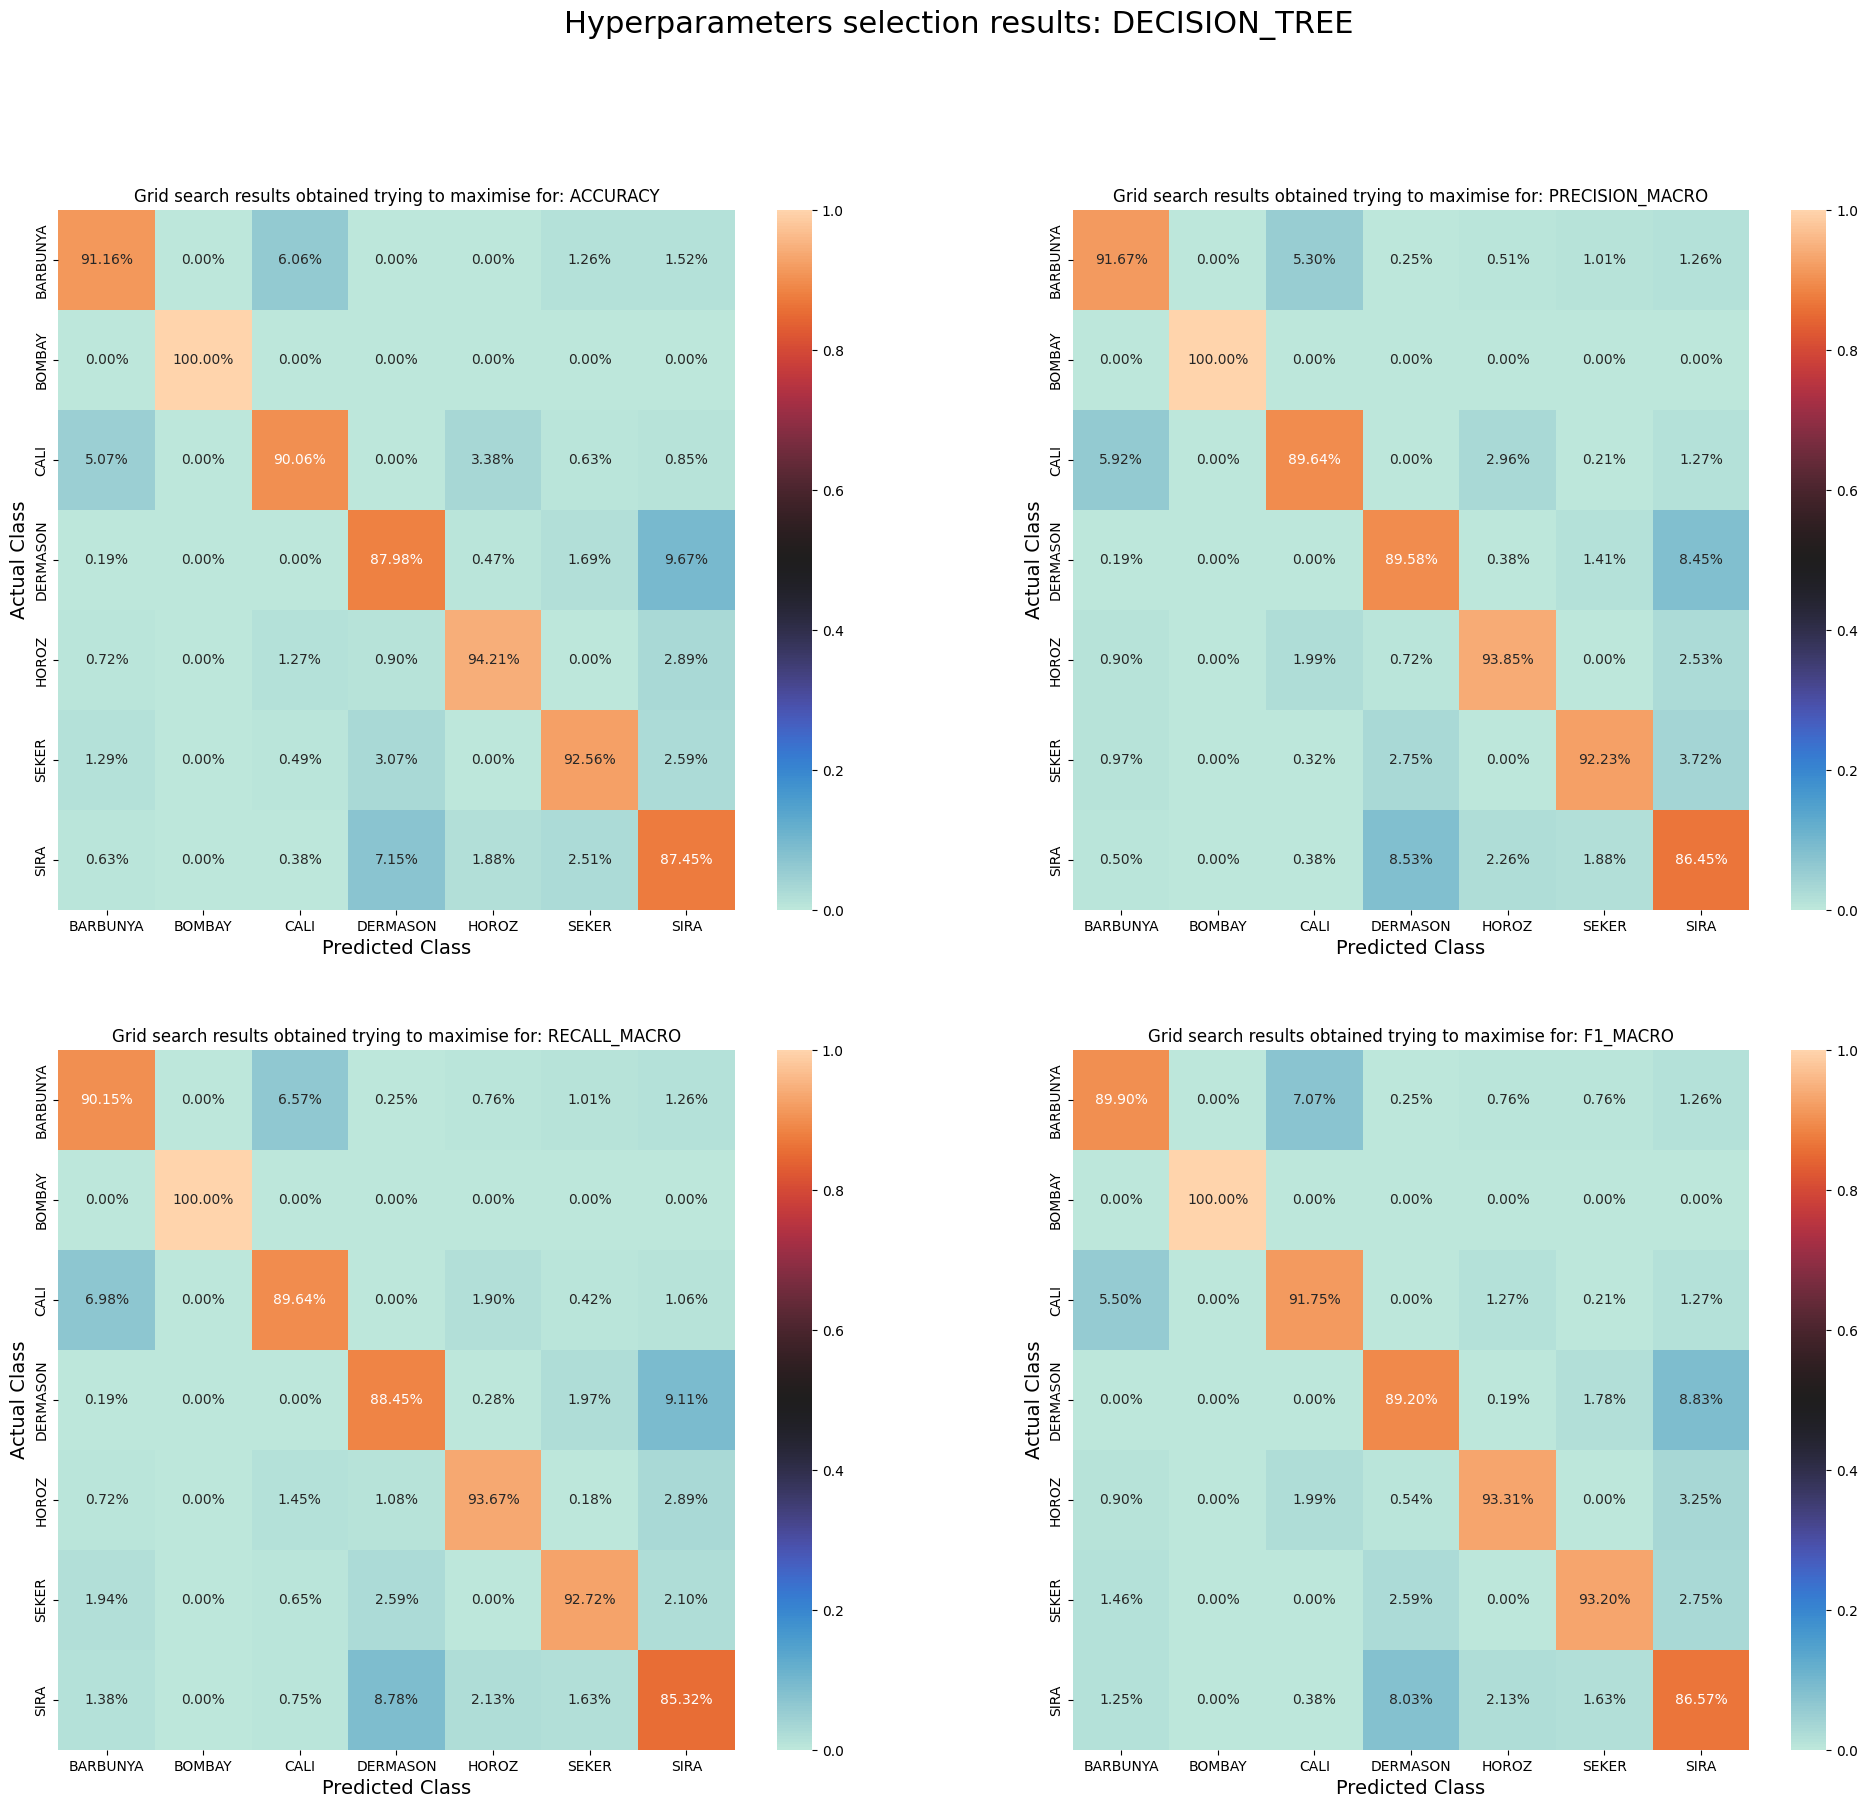

In [29]:
# Hyper-parameter optimization using k-fold cross validation: estimation of the classifier's parameters that maximise specific metrics/scores

models = {
    "Decision_Tree": DecisionTreeClassifier(

        ),
    # "Random_Forest": RandomForestClassifier(
    #     min_samples_leaf=1, max_depth = None, bootstrap = True, 
    #     oob_score = False, min_samples_split = 2,
    #     ),
    # "Extra_Trees": ExtraTreesClassifier(
    #     min_samples_leaf=1, max_depth = None, bootstrap = False, 
    #     oob_score = False, min_samples_split = 2,
    #     ),
    # "KNN": KNeighborsClassifier(
    #     ),
    # "SVM": SVC(
    #     class_weight='balanced' 
        # ),
    # "MLP": MLPClassifier( 
    #     alpha=1e-5, 
    #     learning_rate='constant',
    #     max_iter=1000,
    #     tol=1e-4,
    #     verbose=False,
    #     momentum=0.9,
    #     early_stopping=False,
    #     )
}

# Set the parameters by cross-validation for different models
models_parameters_grids = {
    "Decision_Tree":
        {
            "Decision_Tree__criterion": ["gini"],  # "gini", "entropy", "log_loss"
            "Decision_Tree__splitter": ["best"],
            "Decision_Tree__max_depth": [12]  # [8, 10, 12, 15],
        },
    # "Random_Forest":
    #     {
    #         "Random_Forest__n_estimators": [128], 
    #         "Random_Forest__criterion": ["entropy"],                    # {"gini", "entropy", "log_loss"}
    #         "Random_Forest__max_features": ["log2"],                    # {"sqrt", "log2", None}
    #     },
    # "Extra_Trees":   
    #     {
    #         "Extra_Trees__n_estimators":  [256], 
    #         "Extra_Trees__criterion": ["log_loss"],           # {"gini", "entropy", "log_loss"}
    #         "Extra_Trees__max_features": [None],                 # {"sqrt", "log2", None}
    #     },
    # "KNN": 
    #     {   
    #         'KNN__weights': ['uniform', 'distance'],
    #         'KNN__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    #         'KNN__n_neighbors': [5, 10, 15],
    #         'KNN__p': [2,1],
    #     },
    # "SVM": 
    #     [
    #         {
    #             'SVM__kernel': ['rbf'],
    #             'SVM__gamma': np.linspace(0.01, 0.1, 5),
    #             'SVM__C': np.linspace(10, 100, 5),
    #             'SVM__decision_function_shape': ['ovo', 'ovr'],  # by default this is set to ovr
    #         },   
    
    #         {   
    #             # 'SVM__kernel': ['linear'],
    #             # 'SVM__C': [1, 10, 100],
    #             # 'SVM__decision_function_shape': ['ovo'],
    #         }
    #     ],
    # "MLP":
    #         {
    #             'MLP__activation': ['identity', 'logistic', 'tanh', 'relu'],    # {identity', 'logistic', 'tanh', 'relu'}
    #             'MLP__solver': ['adam',],     # {'lbfgs', 'sgd', 'adam'}
    #             'MLP__hidden_layer_sizes': [(12, 3), (16, 16)], 
    #             'MLP__learning_rate_init': [0.3, 0.1, 0.01],
    #         }
}

# Choose the metrics to optimize for
# scores = ['accuracy']
scores = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

models_best_parameters  = {
    "Decision_Trees": {},
    # "Random_Forest": {},
    # "Extra_Trees": {},
    # "KNN": {},
    # "SVM": {},
    # "MLP": {}
}

for model_name in models:
    # Creates a pipeline with the selected model (this is only done in order to apply the class balancing during correctly during k-fold cross validation)
    # No grid search is performed on different combinations of pre-processing parameters
    pipe = Pipeline([['over', SMOTETomek()], ['scaler', StandardScaler()], [model_name, models.get(model_name)]])  
    model_best_parameters = model_grid_search(X_train, X_test, y_train, y_test, scores, pipe, model_name, models_parameters_grids.get(model_name), n_cv=5)
    models_best_parameters[model_name] = model_best_parameters

In [30]:
models_best_parameters

{'Decision_Trees': {},
 'Decision_Tree': {'accuracy': {'Decision_Tree__criterion': 'gini',
   'Decision_Tree__max_depth': 12,
   'Decision_Tree__splitter': 'best'},
  'precision_macro': {'Decision_Tree__criterion': 'gini',
   'Decision_Tree__max_depth': 12,
   'Decision_Tree__splitter': 'best'},
  'recall_macro': {'Decision_Tree__criterion': 'gini',
   'Decision_Tree__max_depth': 12,
   'Decision_Tree__splitter': 'best'},
  'f1_macro': {'Decision_Tree__criterion': 'gini',
   'Decision_Tree__max_depth': 12,
   'Decision_Tree__splitter': 'best'}}}

## Final Testing

In this section we perform a simple training using all training samples (no-cross validation) and testing using the set of best parameters that maximise the selected score.

It is possible to select one among these models:
 - Decision_Tree;
 - Random_Forest;
 - Extra_Tree;
 - KNN;
 - SVM;
 - MLP

It is possible to select one among these scores:
 - accuracy;
 - precision_macro;
 - recall_macro;
 - f1_score_macro

 It is possible to create a pipeline selecting some pre-processing operations. The default ones are the same used in the grid search:
 - Smote oversampling technique for balancing the classes
 - StandardScaler that removes the mean and divides by the stardand deviations of each feature distribution. 

In [31]:
"""
Code to parse sklearn classification_report
Original: https://gist.github.com/julienr/6b9b9a03bd8224db7b4f
Modified to work with Python 3 and classification report averages
""" 

import sys
import collections

def parse_classification_report(clfreport):
    """
    Parse a sklearn classification report into a dict keyed by class name
    and containing a tuple (precision, recall, fscore, support) for each class
    """
    lines = clfreport.split('\n')
    # Remove empty lines
    lines = list(filter(lambda l: not len(l.strip()) == 0, lines))
    lines=[s for s in lines if 'accuracy' not in s]

    # Starts with a header, then score for each class and finally an average
    header = lines[0]
    cls_lines = lines[1:-1]
    avg_line = lines[-1]

    assert header.split() == ['precision', 'recall', 'f1-score', 'support']
    assert avg_line.split()[1] == 'avg'

    # We cannot simply use split because class names can have spaces. So instead
    # figure the width of the class field by looking at the indentation of the
    # precision header
    cls_field_width = len(header) - len(header.lstrip())
    # Now, collect all the class names and score in a dict
    def parse_line(l):
        """Parse a line of classification_report"""
        cls_name = l[:cls_field_width].strip()
        precision, recall, fscore, support = l[cls_field_width:].split()
        precision = float(precision)
        recall = float(recall)
        fscore = float(fscore)
        support = int(support)
        return (cls_name, precision, recall, fscore, support)

    data = collections.OrderedDict()
    for l in cls_lines:
        ret = parse_line(l)
        cls_name = ret[0]
        scores = ret[1:]
        data[cls_name] = scores

    # average
    data['avg'] = parse_line(avg_line)[1:]

    return data

def report_to_latex_table(data):
    avg_split = False
    out = ""
    out += "\\begin{table}\n"
    out += "\\caption{Latex Table from Classification Report}\n"
    out += "\\label{table:classification:report}\n"
    out += "\\centering\n"
    out += "\\begin{tabular}{c | c c c r}\n"
    out += "Class & Precision & Recall & F-score & Support\\\\\n"
    out += "\midrule\n"
    for cls, scores in data.items():
        if 'micro' in cls:
            out += "\\midrule\n"
        out += cls + " & " + " & ".join([str(s) for s in scores])
        out += "\\\\\n"
    out += "\\end{tabular}\n"
    out += "\\end{table}"
    return out

 ---> List of the parameters used according to a specific scoring parameter: <--- 

{
    "accuracy":{
        "Decision_Tree__criterion":"gini",
        "Decision_Tree__max_depth":12,
        "Decision_Tree__splitter":"best"
    },
    "precision_macro":{
        "Decision_Tree__criterion":"gini",
        "Decision_Tree__max_depth":12,
        "Decision_Tree__splitter":"best"
    },
    "recall_macro":{
        "Decision_Tree__criterion":"gini",
        "Decision_Tree__max_depth":12,
        "Decision_Tree__splitter":"best"
    },
    "f1_macro":{
        "Decision_Tree__criterion":"gini",
        "Decision_Tree__max_depth":12,
        "Decision_Tree__splitter":"best"
    }
}


# Classification:

 ---> Model training:

   (!) Using the set of hyperparameters found doing grid seach trying to maximise ACCURACY

 ---> Making predictions:

    Plotting the Confusion Matrix:

[[359   0  33   0   1   2   1]
 [  0 161   0   0   0   0   0]
 [ 31   0 428   0  10   1   3]
 [  0   0   0 963   4 

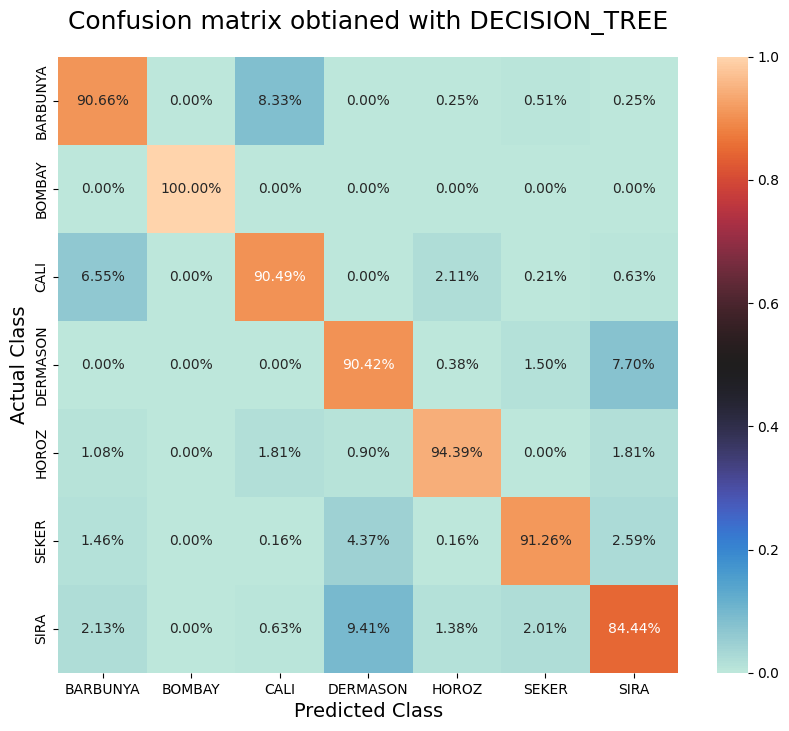

In [32]:
# Simple classification with a selected pipeline (pre_processing and model) and a selected score

# selection of a particular configuration (same used in grid search!)
class_balancer = SMOTETomek()
scaler = StandardScaler()
model_name = 'Decision_Tree'
selected_score = 'accuracy'

# Generating pipeline and picking the correct parameters
pipe = Pipeline([['over', class_balancer], ['scaler', scaler], [model_name, models.get(model_name)]])  
model_best_param = models_best_parameters[model_name]

clf, report = pipeline_final_traintest(X_train, X_test, y_train, y_test, selected_score, pipe, model_name, model_best_param)

# Print the classification report and convert it to LaTeX
# print(report_to_latex_table(parse_classification_report(report)))

#### Plotting a small decision tree

In [33]:
# from graphviz import Source
# from sklearn.tree import export_graphviz
# import os

# # features = ['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'AspectRatio', 'Eccentricity', 'ConvexArea', 'EquivalentDiameter', 
# #             'Extent', 'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2','ShapeFactor3', 'ShapeFactor4']

# features = ['AspectRatio', 'Extent', 'Solidity', 'Roundness', 'ShapeFactor1', 'ShapeFactor4']

# classes = ['BARBUNYA', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA']

# export_graphviz(
#         pipe['Decision_Tree'],
#         out_file=os.path.join('images/', "beans_tree.dot"),
#         feature_names= features,
#         class_names = pipe['Decision_Tree'].classes_,
#         rounded=True,
#         filled=True
#     )

# Source.from_file(os.path.join('images/',"beans_tree.dot"))

#### More on scoring: ROC curves

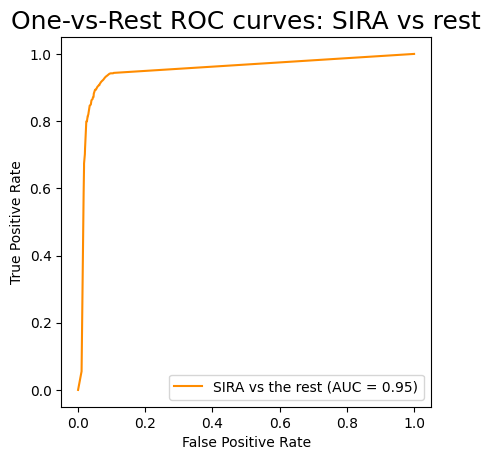

In [34]:
#SCORING

# CLASSES: ['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA']

y_score = clf.predict_proba(X_test)
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)
label_binarizer.transform(["SIRA"])

class_of_interest = "SIRA"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

met.RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: " + class_of_interest + " vs rest", fontsize=18)
plt.legend()

# FPR = 1 when threshold = 0% or TN = 0
# TPR = 0 when threshold = 1000% or TP = 0